# the Apache License, Version 2.0

**allows for commercial use. This license provides a permissive open source license with several key features, including**:
* Commercial Use: You are free to use, distribute, and sell the software, including as part of a larger project.
* Modification: You can modify the software as you see fit.
* Distribution: You can distribute the original or modified software.
* Patent Rights: It provides an express grant of patent rights from contributors to users.
* Conditions: You must include a copy of the license and provide a notice of any changes made when distributing the software.

# Pose Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect pose landmarks from images.

## Preparation

* install mediapipe package

In [1]:
!pip install -q mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 28.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


Then download an off-the-shelf model bundle. this model will be used for human body pose estimation

In [2]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

## Visualization utilities

In [3]:

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

## Download test image

To demonstrate the Pose Landmarker API, we will download a sample image using the follow code. The image is from [Unsplash](https://unsplash.com/photos/man-crouching-in-middle-of-road--Ucu1JeJfRQ).

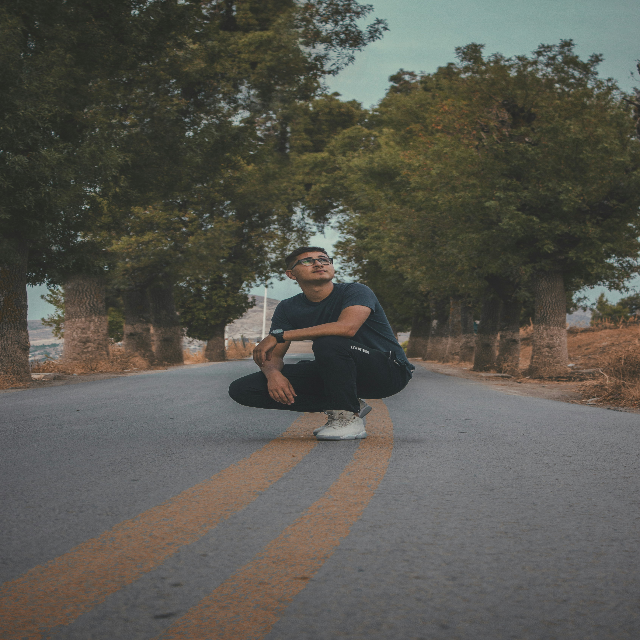

In [4]:
!wget -q -O image3.jpg https://images.unsplash.com/photo-1573946327765-4252b4ea46c2?q=80&w=1370&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D

import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("image3.jpg")
img = cv2.resize(img, (640, 640))
cv2.imwrite("image3.jpg", img)
cv2_imshow(img)

## Running inference and visualizing the results

The final step is to run pose landmark detection on your selected image. This involves creating your PoseLandmarker object, loading your image, running detection, and finally, the optional step of displaying the image with visualizations.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker/python) to learn more about configuration options that this solution supports.


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


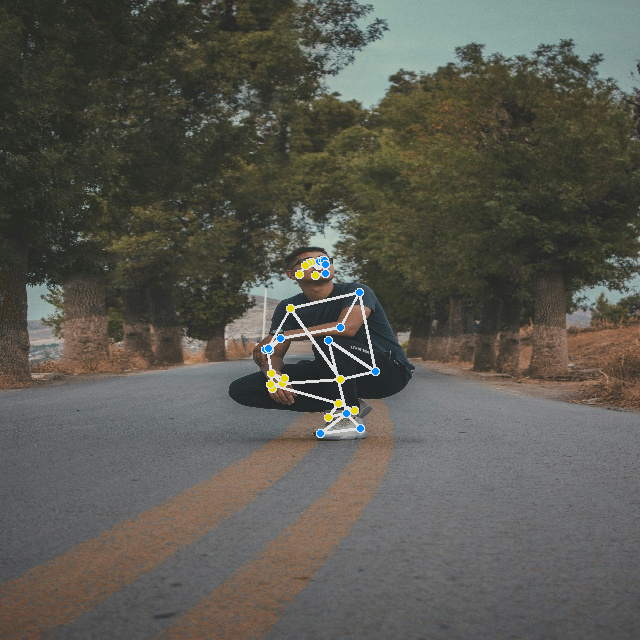

In [5]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image3.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
annotated_image = cv2.resize(annotated_image, (640, 640))
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

# Angle Calculation

Lets see the points we are getting from the model. The model is supposed to give us 3-dimensional points for each of the marker point. lets print the 3 points in left hand

In [6]:
# Process the detection result
pose_landmarks = detection_result.pose_landmarks[0]  # Assuming only one pose is detected
landmarks = pose_landmarks

# Example points on the left hand: wrist, elbow, shoulder
left_wrist = landmarks[mp.solutions.pose.PoseLandmark.LEFT_WRIST]
left_elbow = landmarks[mp.solutions.pose.PoseLandmark.LEFT_ELBOW]
left_shoulder = landmarks[mp.solutions.pose.PoseLandmark.LEFT_SHOULDER]

print(left_wrist)
print(left_elbow)
print(left_shoulder)


NormalizedLandmark(x=0.43863359093666077, y=0.5291541218757629, z=-0.3735150396823883, visibility=0.9940620064735413, presence=0.99998939037323)
NormalizedLandmark(x=0.5326647758483887, y=0.5117303133010864, z=-0.28235021233558655, visibility=0.9950776696205139, presence=0.9999436140060425)
NormalizedLandmark(x=0.5612331628799438, y=0.4577541947364807, z=-0.15848901867866516, visibility=0.9999921321868896, presence=0.999998927116394)


**Function to calculate the angle between three points**

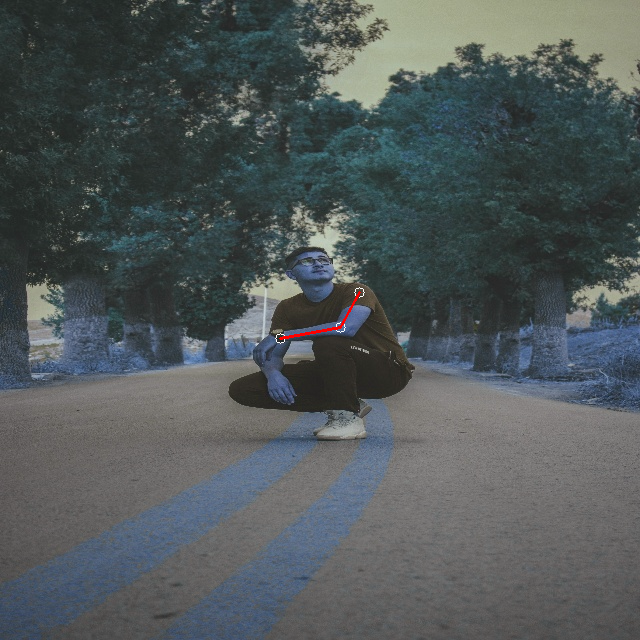

True

In [7]:
# Extract left wrist, elbow, and shoulder
left_wrist = landmarks[mp.solutions.pose.PoseLandmark.LEFT_WRIST]
left_elbow = landmarks[mp.solutions.pose.PoseLandmark.LEFT_ELBOW]
left_shoulder = landmarks[mp.solutions.pose.PoseLandmark.LEFT_SHOULDER]

# Convert normalized coordinates to pixel coordinates
points = []

height,width,_ = image.numpy_view().shape

for landmark in [left_wrist, left_elbow, left_shoulder]:
    x = int(landmark.x * width)
    y = int(landmark.y * height)
    points.append((x, y))

# Draw the points
for point in points:
    cv2.circle(image.numpy_view(), point, 5, (255, 255, 255))

# Connect the points with red lines
cv2.line(image.numpy_view(), points[0], points[1], (0, 0, 255), 2)  # Wrist to Elbow
cv2.line(image.numpy_view(), points[1], points[2], (0, 0, 255), 2)  # Elbow to Shoulder

img = cv2.resize(image.numpy_view(), (640, 640))
# Display the image
cv2_imshow( img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Save the image (optional)
cv2.imwrite('image_with_landmarks.jpg', image.numpy_view())

In [8]:

def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle

In [9]:
# Calculate the angle at the left elbow
angle = calculate_angle(
    (left_wrist.x, left_wrist.y),
    (left_elbow.x, left_elbow.y),
    (left_shoulder.x, left_shoulder.y)
)

print(f"Angle at the left elbow: {angle} degrees")


Angle at the left elbow: 128.3890337996665 degrees


# Additional, Segmentation resuls

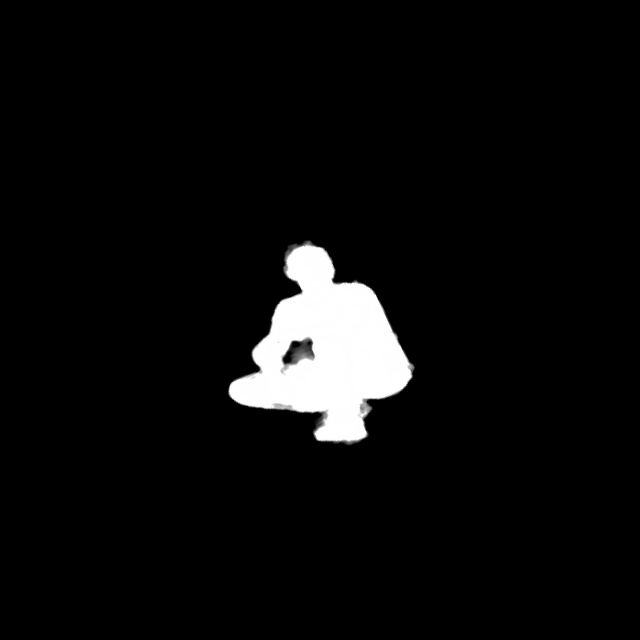

In [10]:
segmentation_mask = detection_result.segmentation_masks[0].numpy_view()
visualized_mask = np.repeat(segmentation_mask[:, :, np.newaxis], 3, axis=2) * 255
visualized_mask = cv2.resize(visualized_mask, (640, 640))
cv2_imshow(visualized_mask)